**Table of contents**<a id='toc0_'></a>    
- [Projekat 3 - duboko učenje](#toc1_)    
  - [Učitavanje *dataset*-a](#toc1_1_)    
  - [Kreiranje modela](#toc1_2_)    
    - [*ImageDataGenerator*](#toc1_2_1_)    
    - [*Callbacks*](#toc1_2_2_)    
    - [*Custom Loss Function*](#toc1_2_3_)    
    - [*Forcing overfitting*](#toc1_2_4_)    
    - [Najbolji model](#toc1_2_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Projekat 3 - duboko učenje](#toc0_)

**Dataset**: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

**Definicija problema**: Klasifikacija slika za papir-kamen-makaze

**Vrsta problema**: višeklasna klasifikacija

## <a id='toc1_1_'></a>[Učitavanje *dataset*-a](#toc0_)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import cv2
import os
import random
import tensorflow as tf

In [2]:
main_directory = 'dataset/'
subfolders = ['paper','rock','scissors']

dataset=[]
label=0
for subfolder in subfolders:
    folder = os.path.join(main_directory,subfolder)
    for image in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (75, 50))

        img = img/255.0
        dataset.append((img,label))
    label+=1
random.shuffle(dataset)
X, y =zip(*dataset)

X = np.array(X)
y = np.array(y)

*Dataset* se sastoji od slika položaja šake za papir, kamen i makaze. 

Slike se učitavaju u RGB formatu, i zatim se skaliraju na manje dimenzije. Ovakva reprezentacija se pretapa u *numpy* niz, a vrednosti svakog elementa skaliraju u odnosu na 255, što je maksimalna vrednost jednog piksela slike. 

Kroz samo učitavanje slika, enkodiraju se i kategoričke labele u sledećem formatu:
- 0 - *paper*
- 1 - *rock*
- 2 - *scissors*

Na ovaj način se kreiraju *feature* vektor i *target* vektor. *Shuffle* funkcija se koristi da izmeša uzorke tako da u kasnijem treniranju mreže ne dođe do *bias*-a usled sukcesivnih podataka koji pripadaju istoj klasi.

In [3]:
print(X.shape)

(2188, 50, 75, 3)


Oblik *feature* vektora govori da se u *dataset*-u nalazi 2188 uzoraka, i da je svaka slika enkodirana kao 3 matrice **float** vrednosti dimenzija 75x50, gde svaka matrica predstavlja jedan kanal boje. 

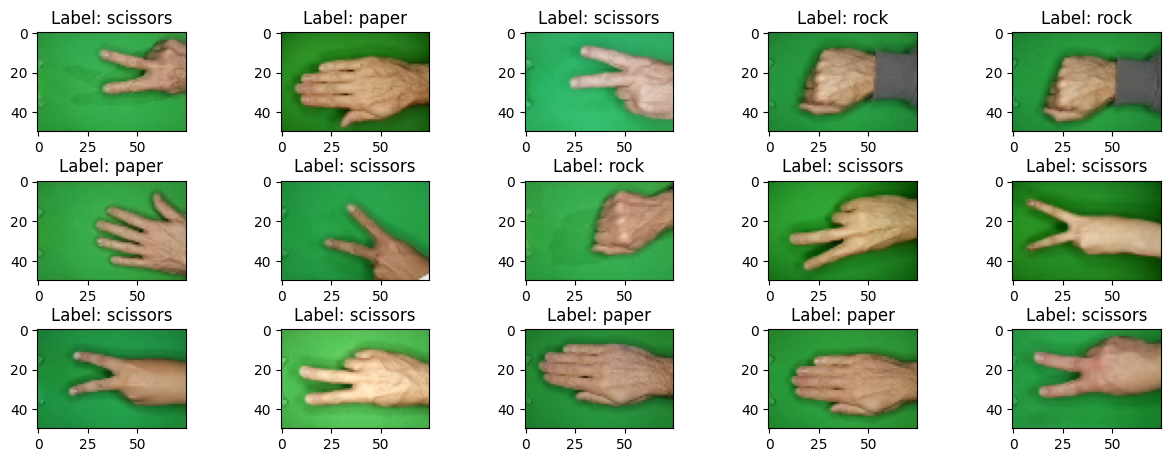

In [4]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5, 5, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
    plt.imshow(X[i])
    plt.title(f'Label: {subfolders[y[i]]}')

Grafik iznad prikazuje izgled učitanih i skaliranih slika.

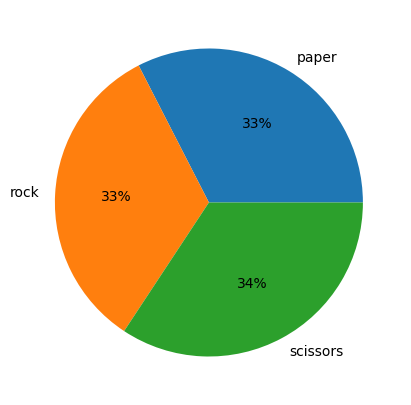

In [5]:
plt.figure(figsize=(7, 5))
unique, counts = np.unique(y,return_counts=True)

pie = plt.pie(counts,labels = subfolders, autopct='%1.0f%%')
plt.show()

Grafik iznad prikazuje distribuciju podataka po klasama. Uočava se da je u pitanju gotovo idealna podela, gde svaka klasa ima jednak broj uzoraka.

## <a id='toc1_2_'></a>[Kreiranje modela](#toc0_)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2)

In [7]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [8]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=(50,75,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 71, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 35, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 35, 64)        0         
                                                                 
 flatten (Flatten)           (None, 51520)             0         
                                                                 
 dense (Dense)               (None, 128)               6594688   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [10]:
history = model.fit(X_train,y_train,epochs=25,verbose=2,batch_size=64,validation_data=(X_test,y_test))

Epoch 1/25
28/28 - 3s - loss: 1.4127 - accuracy: 0.5474 - val_loss: 0.5733 - val_accuracy: 0.8447 - 3s/epoch - 106ms/step
Epoch 2/25
28/28 - 1s - loss: 0.5803 - accuracy: 0.7914 - val_loss: 0.3803 - val_accuracy: 0.8721 - 536ms/epoch - 19ms/step
Epoch 3/25
28/28 - 1s - loss: 0.4528 - accuracy: 0.8474 - val_loss: 0.2851 - val_accuracy: 0.8973 - 543ms/epoch - 19ms/step
Epoch 4/25
28/28 - 1s - loss: 0.2895 - accuracy: 0.8903 - val_loss: 0.2504 - val_accuracy: 0.9132 - 574ms/epoch - 20ms/step
Epoch 5/25
28/28 - 1s - loss: 0.2408 - accuracy: 0.9051 - val_loss: 0.1778 - val_accuracy: 0.9361 - 601ms/epoch - 21ms/step
Epoch 6/25
28/28 - 1s - loss: 0.1983 - accuracy: 0.9320 - val_loss: 0.1973 - val_accuracy: 0.9361 - 675ms/epoch - 24ms/step
Epoch 7/25
28/28 - 1s - loss: 0.1896 - accuracy: 0.9303 - val_loss: 0.1643 - val_accuracy: 0.9406 - 574ms/epoch - 20ms/step
Epoch 8/25
28/28 - 1s - loss: 0.1603 - accuracy: 0.9457 - val_loss: 0.1143 - val_accuracy: 0.9566 - 548ms/epoch - 20ms/step
Epoch 9/25

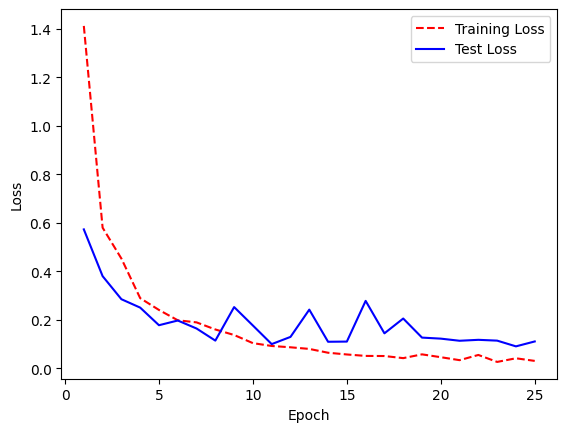

In [11]:
def visualizeLoss(history):
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    epoch_count = range(1,len(training_loss)+1)

    plt.plot(epoch_count,training_loss,"r--")
    plt.plot(epoch_count,test_loss,"b-")
    plt.legend(["Training Loss","Test Loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
visualizeLoss(history=history)

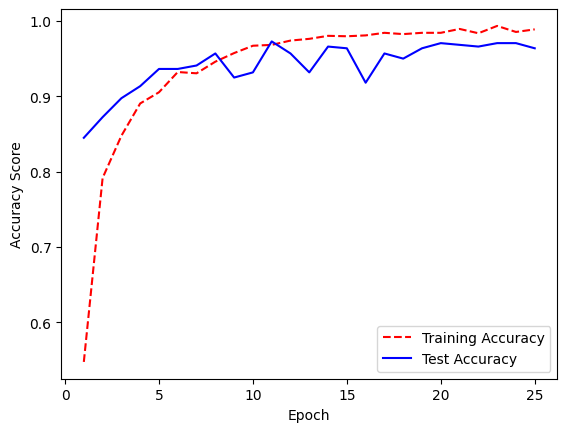

In [12]:
def visualizeAccuracy(history):
    training_accuracy = history.history['accuracy']
    test_accuracy = history.history['val_accuracy']

    epoch_count = range(1,len(training_accuracy)+1)

    plt.plot(epoch_count,training_accuracy,"r--")
    plt.plot(epoch_count,test_accuracy,"b-")
    plt.legend(["Training Accuracy","Test Accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy Score")
    plt.show()
visualizeAccuracy(history=history)

In [13]:
print(model.evaluate(X_test,y_test,batch_size=64))

7/7 [==============================] - 0s 6ms/step - loss: 0.1109 - accuracy: 0.9635
[0.11085730791091919, 0.9634703397750854]


Sa ovakvom mrežom postignuta je tačnost od 96,8% sa gubitkom od 0.1152. Na osnovu vizuelizacije za *accuracy score* i *loss* po epohama, vidi se da model nije idealan i da treba poraditi na njemu.

### <a id='toc1_2_1_'></a>[*ImageDataGenerator*](#toc0_)

Poželjno je uneti varijacije u podatke kako bi se poboljšala tačnost klasifikacije. Iz tog razloga koristimo *ImageDataGenerator* za augmentaciju slika:

In [14]:
from keras.preprocessing.image import ImageDataGenerator

augmentation = ImageDataGenerator(
                                  zoom_range=0.2,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  vertical_flip=True,
                                  horizontal_flip=True,
                                  rotation_range=20, #preko 20 ruka moze da se odsece sa slike
                                  fill_mode='nearest'
                                  )
test_augmentation = ImageDataGenerator(validation_split=0.5)

augmentation.fit(X_train)
test_augmentation.fit(X_test)

train_data = augmentation.flow(X_train,y_train,batch_size=64)
test_data = test_augmentation.flow(X_test,y_test,batch_size=64,subset="training")
validation_data = test_augmentation.flow(X_test,y_test,batch_size=64,subset="validation")

In [15]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=(50,75,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 46, 71, 64)        4864      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 33, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 14, 128)        36992     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 7, 128)       

In [16]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

c:\Users\Nikola\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
history = model.fit(train_data,epochs=50,verbose=2,batch_size=64,validation_data=validation_data)

Epoch 1/50
28/28 - 3s - loss: 1.0799 - accuracy: 0.3794 - val_loss: 0.8734 - val_accuracy: 0.6712 - 3s/epoch - 93ms/step
Epoch 2/50
28/28 - 2s - loss: 0.8097 - accuracy: 0.6223 - val_loss: 0.3601 - val_accuracy: 0.8950 - 2s/epoch - 63ms/step
Epoch 3/50
28/28 - 2s - loss: 0.5380 - accuracy: 0.8034 - val_loss: 0.2084 - val_accuracy: 0.9269 - 2s/epoch - 62ms/step
Epoch 4/50
28/28 - 2s - loss: 0.4387 - accuracy: 0.8326 - val_loss: 0.1401 - val_accuracy: 0.9498 - 2s/epoch - 62ms/step
Epoch 5/50
28/28 - 2s - loss: 0.4060 - accuracy: 0.8531 - val_loss: 0.1219 - val_accuracy: 0.9726 - 2s/epoch - 61ms/step
Epoch 6/50
28/28 - 2s - loss: 0.3358 - accuracy: 0.8783 - val_loss: 0.2468 - val_accuracy: 0.8995 - 2s/epoch - 61ms/step
Epoch 7/50
28/28 - 2s - loss: 0.3478 - accuracy: 0.8703 - val_loss: 0.0961 - val_accuracy: 0.9726 - 2s/epoch - 61ms/step
Epoch 8/50
28/28 - 2s - loss: 0.2670 - accuracy: 0.9023 - val_loss: 0.0799 - val_accuracy: 0.9680 - 2s/epoch - 61ms/step
Epoch 9/50
28/28 - 2s - loss: 0.

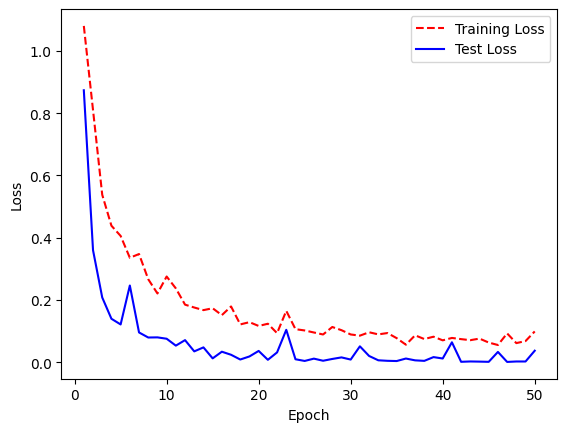

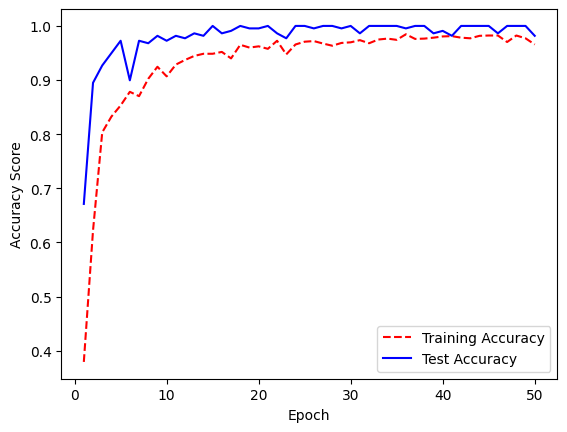

In [18]:
visualizeLoss(history=history)
visualizeAccuracy(history=history)

In [19]:
print(model.evaluate(test_data))

4/4 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.9954
[0.04013177752494812, 0.9954338073730469]


Razlika u tačnosti je vidna uz korišćenje augmentacije slika. Takođe, sa grafika se može uočiti da model bolje konvergira ka rešenju.

### <a id='toc1_2_2_'></a>[*Callbacks*](#toc0_)

Model se potencijalno može poboljšati uz korišćenje nekih tehnika kao što su:
- *early stopping*
- snimanje modela na nekom *checkpoint*-u 
- smanjenje *learning rate* parametra

Ove tehnike su isprobane u sledećem delu koda:

In [20]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=(50,75,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 71, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 35, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 33, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 14, 128)        36992     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 7, 128)        0

In [21]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor="val_loss", patience=5)
checkpoint = ModelCheckpoint(filepath="best_model.h5",monitor="val_loss",save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)
callbacks=[earlyStopping,checkpoint,reduce_lr]

In [23]:
history = model.fit(train_data,epochs=50,verbose=2,batch_size=64,callbacks=callbacks,validation_data=validation_data)

Epoch 1/50
28/28 - 3s - loss: 1.0994 - accuracy: 0.3554 - val_loss: 1.0364 - val_accuracy: 0.3607 - lr: 0.0010 - 3s/epoch - 115ms/step
Epoch 2/50
28/28 - 3s - loss: 0.9486 - accuracy: 0.5257 - val_loss: 0.5844 - val_accuracy: 0.6712 - lr: 0.0010 - 3s/epoch - 101ms/step
Epoch 3/50
28/28 - 2s - loss: 0.6361 - accuracy: 0.7377 - val_loss: 0.4470 - val_accuracy: 0.8721 - lr: 0.0010 - 2s/epoch - 68ms/step
Epoch 4/50
28/28 - 3s - loss: 0.5165 - accuracy: 0.7851 - val_loss: 0.3016 - val_accuracy: 0.9178 - lr: 0.0010 - 3s/epoch - 117ms/step
Epoch 5/50
28/28 - 4s - loss: 0.4907 - accuracy: 0.7971 - val_loss: 0.3389 - val_accuracy: 0.8493 - lr: 0.0010 - 4s/epoch - 159ms/step
Epoch 6/50
28/28 - 2s - loss: 0.4316 - accuracy: 0.8303 - val_loss: 0.1479 - val_accuracy: 0.9498 - lr: 0.0010 - 2s/epoch - 81ms/step
Epoch 7/50
28/28 - 2s - loss: 0.3651 - accuracy: 0.8720 - val_loss: 0.1350 - val_accuracy: 0.9680 - lr: 0.0010 - 2s/epoch - 75ms/step
Epoch 8/50
28/28 - 3s - loss: 0.4029 - accuracy: 0.8434 - 

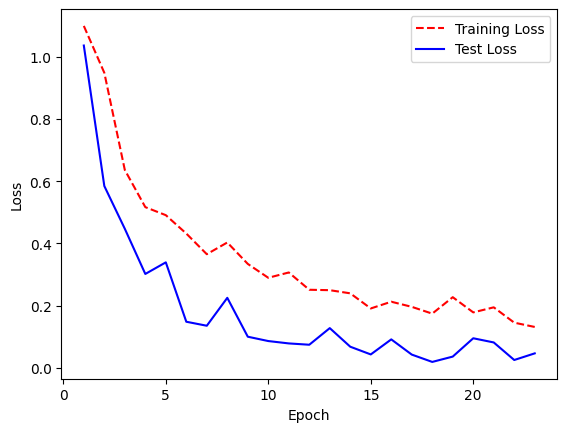

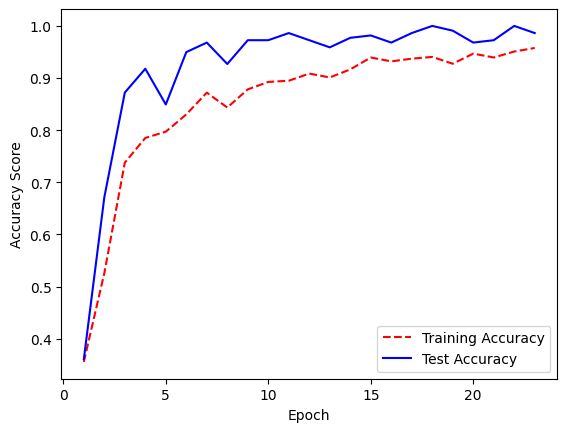

In [24]:
visualizeLoss(history=history)
visualizeAccuracy(history=history)

In [25]:
model = tf.keras.models.load_model('best_model.h5')

In [26]:
print(model.evaluate(test_data))

4/4 [==============================] - 0s 7ms/step - loss: 0.0647 - accuracy: 0.9909
[0.06469155102968216, 0.990867555141449]


Korišćenjem sva tri definisana callback-a dobija se manja tačnost od prethodne. Pokušaćemo sa izbacivanjem modifikacije *learning rate* parametra:

In [27]:
checkpoint = ModelCheckpoint(filepath="best_model_without_LR.h5",monitor="val_loss",save_best_only=True)
callbacks=[earlyStopping,checkpoint]

In [28]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=(50,75,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 71, 64)        4864      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 33, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 14, 128)        36992     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 7, 128)       

In [29]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
history = model.fit(train_data,epochs=50,verbose=2,batch_size=64,callbacks=callbacks,validation_data=validation_data)

Epoch 1/50
28/28 - 4s - loss: 1.0879 - accuracy: 0.3920 - val_loss: 0.9649 - val_accuracy: 0.5297 - 4s/epoch - 127ms/step
Epoch 2/50
28/28 - 3s - loss: 0.9221 - accuracy: 0.5589 - val_loss: 0.4191 - val_accuracy: 0.8950 - 3s/epoch - 101ms/step
Epoch 3/50
28/28 - 5s - loss: 0.5801 - accuracy: 0.7777 - val_loss: 0.1979 - val_accuracy: 0.9361 - 5s/epoch - 172ms/step
Epoch 4/50
28/28 - 2s - loss: 0.5035 - accuracy: 0.7977 - val_loss: 0.1639 - val_accuracy: 0.9589 - 2s/epoch - 87ms/step
Epoch 5/50
28/28 - 2s - loss: 0.4026 - accuracy: 0.8440 - val_loss: 0.1658 - val_accuracy: 0.9452 - 2s/epoch - 76ms/step
Epoch 6/50
28/28 - 3s - loss: 0.3883 - accuracy: 0.8514 - val_loss: 0.1847 - val_accuracy: 0.9452 - 3s/epoch - 119ms/step
Epoch 7/50
28/28 - 3s - loss: 0.3805 - accuracy: 0.8594 - val_loss: 0.1186 - val_accuracy: 0.9772 - 3s/epoch - 113ms/step
Epoch 8/50
28/28 - 3s - loss: 0.3572 - accuracy: 0.8646 - val_loss: 0.1738 - val_accuracy: 0.9726 - 3s/epoch - 124ms/step
Epoch 9/50
28/28 - 3s - lo

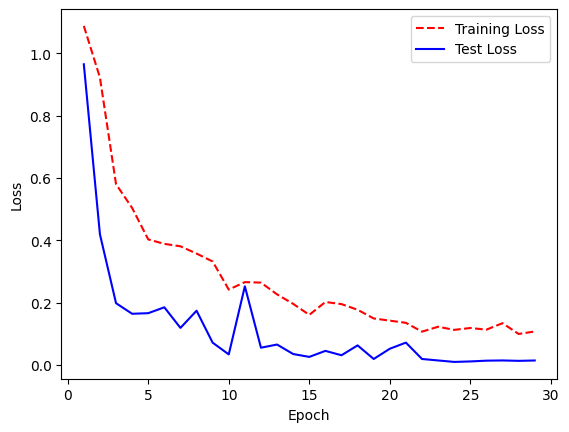

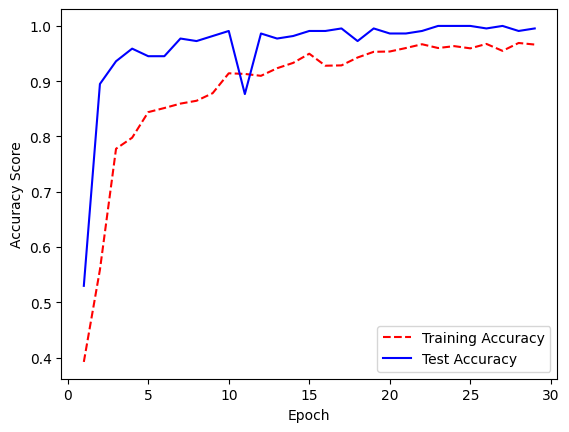

In [31]:
visualizeLoss(history=history)
visualizeAccuracy(history=history)

In [32]:
model = tf.keras.models.load_model('best_model_without_LR.h5')

In [33]:
print(model.evaluate(test_data))

4/4 [==============================] - 0s 7ms/step - loss: 0.0444 - accuracy: 0.9909
[0.044445402920246124, 0.990867555141449]


Bez modifikacije *learning rate* parametra dobija se manja loss vrednost.

### <a id='toc1_2_3_'></a>[*Custom Loss Function*](#toc0_)

In [34]:
def customLossFunction(y_true,y_pred):
    log_y_pred = tf.math.log(y_pred)
    elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
    return tf.reduce_mean(tf.reduce_sum(elements,axis=1))

In [35]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=(50,75,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 71, 64)        4864      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 33, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 14, 128)        36992     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 7, 128)       

In [36]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),loss=customLossFunction,metrics=['accuracy'])

In [37]:
checkpoint = ModelCheckpoint(filepath="best_model_with_CLF.h5",monitor="val_loss",save_best_only=True)
callbacks=[earlyStopping,checkpoint]

In [38]:
history = model.fit(train_data,epochs=50,verbose=2,batch_size=64,callbacks=callbacks,validation_data=validation_data)

Epoch 1/50
28/28 - 3s - loss: 1.1021 - accuracy: 0.3349 - val_loss: 1.0789 - val_accuracy: 0.5023 - 3s/epoch - 116ms/step
Epoch 2/50
28/28 - 3s - loss: 1.0559 - accuracy: 0.4457 - val_loss: 0.8955 - val_accuracy: 0.5434 - 3s/epoch - 110ms/step
Epoch 3/50
28/28 - 2s - loss: 0.7534 - accuracy: 0.6817 - val_loss: 0.3020 - val_accuracy: 0.8676 - 2s/epoch - 66ms/step
Epoch 4/50
28/28 - 2s - loss: 0.5215 - accuracy: 0.7920 - val_loss: 0.1807 - val_accuracy: 0.9361 - 2s/epoch - 73ms/step
Epoch 5/50
28/28 - 2s - loss: 0.4545 - accuracy: 0.8189 - val_loss: 0.1655 - val_accuracy: 0.9680 - 2s/epoch - 65ms/step
Epoch 6/50
28/28 - 3s - loss: 0.3825 - accuracy: 0.8554 - val_loss: 0.1993 - val_accuracy: 0.9406 - 3s/epoch - 110ms/step
Epoch 7/50
28/28 - 4s - loss: 0.3877 - accuracy: 0.8600 - val_loss: 0.1345 - val_accuracy: 0.9589 - 4s/epoch - 154ms/step
Epoch 8/50
28/28 - 3s - loss: 0.3378 - accuracy: 0.8811 - val_loss: 0.1552 - val_accuracy: 0.9498 - 3s/epoch - 94ms/step
Epoch 9/50
28/28 - 3s - loss

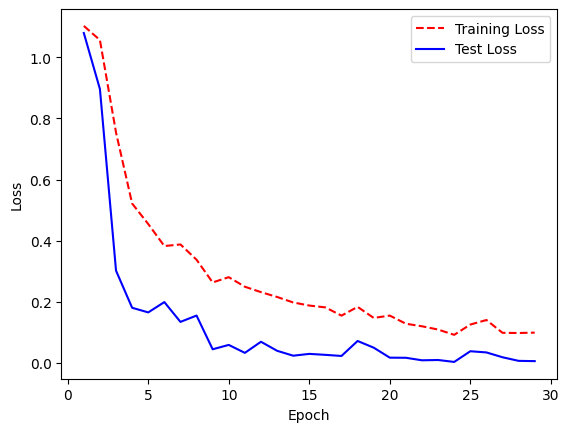

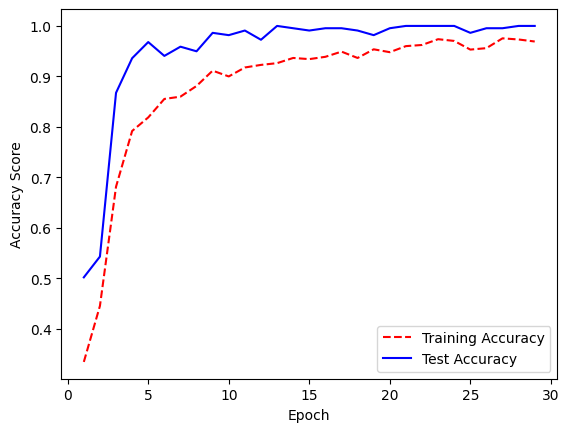

In [39]:
visualizeLoss(history=history)
visualizeAccuracy(history=history)

In [40]:
model = tf.keras.models.load_model('best_model_with_CLF.h5',compile=False)
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),loss=customLossFunction,metrics=['accuracy'])

In [41]:
print(model.evaluate(test_data))

4/4 [==============================] - 0s 5ms/step - loss: 0.0442 - accuracy: 0.9909
[0.04415692389011383, 0.990867555141449]


### <a id='toc1_2_4_'></a>[*Forcing overfitting*](#toc0_)

In [42]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=(50,75,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 71, 64)        4864      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 33, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 14, 128)        36992     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 7, 128)       

In [43]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
history = model.fit(X_train,y_train,epochs=100,verbose=2,batch_size=64,validation_data=(X_test,y_test))

Epoch 1/100
28/28 - 3s - loss: 0.7203 - accuracy: 0.6920 - val_loss: 0.3107 - val_accuracy: 0.8790 - 3s/epoch - 123ms/step
Epoch 2/100
28/28 - 2s - loss: 0.2368 - accuracy: 0.9171 - val_loss: 0.1727 - val_accuracy: 0.9566 - 2s/epoch - 76ms/step
Epoch 3/100
28/28 - 2s - loss: 0.1246 - accuracy: 0.9594 - val_loss: 0.1198 - val_accuracy: 0.9635 - 2s/epoch - 75ms/step
Epoch 4/100
28/28 - 2s - loss: 0.1115 - accuracy: 0.9629 - val_loss: 0.1331 - val_accuracy: 0.9658 - 2s/epoch - 68ms/step
Epoch 5/100
28/28 - 3s - loss: 0.1046 - accuracy: 0.9606 - val_loss: 0.0721 - val_accuracy: 0.9795 - 3s/epoch - 93ms/step
Epoch 6/100
28/28 - 2s - loss: 0.0721 - accuracy: 0.9760 - val_loss: 0.0980 - val_accuracy: 0.9772 - 2s/epoch - 79ms/step
Epoch 7/100
28/28 - 3s - loss: 0.0635 - accuracy: 0.9829 - val_loss: 0.0593 - val_accuracy: 0.9795 - 3s/epoch - 124ms/step
Epoch 8/100
28/28 - 4s - loss: 0.0391 - accuracy: 0.9886 - val_loss: 0.0374 - val_accuracy: 0.9863 - 4s/epoch - 128ms/step
Epoch 9/100
28/28 - 2

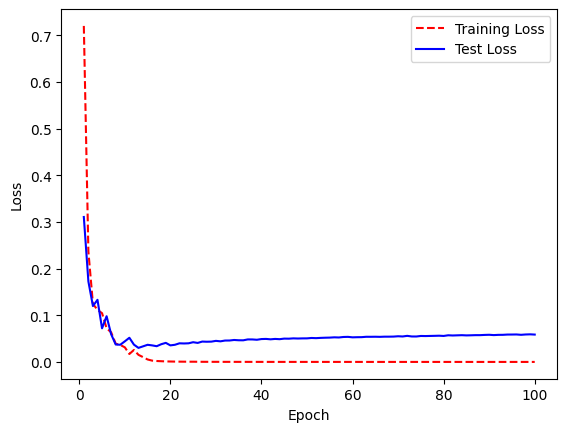

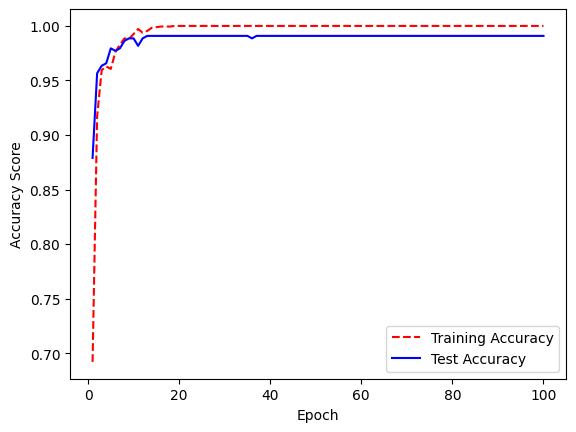

In [45]:
visualizeLoss(history=history)
visualizeAccuracy(history=history)

In [46]:
print(model.evaluate(X_test,y_test))

14/14 [==============================] - 2s 15ms/step - loss: 0.0586 - accuracy: 0.9909
[0.058628588914871216, 0.990867555141449]


### <a id='toc1_2_5_'></a>[Najbolji model](#toc0_)

Primećeno je da se model bolje ponaša kad se izbace *Dropout* slojevi. Pored toga, model dobro reaguje na korišćenje *early stopping*-a i *checkpoint*-a. Iskorišćena je i *custom loss* funkcija. Model je istreniran i evaluiran.

In [64]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=(50,75,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 46, 71, 64)        4864      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 23, 35, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 21, 33, 32)        18464     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 10, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 14, 128)        36992     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 7, 128)       

In [65]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [63]:
checkpoint = ModelCheckpoint(filepath="best_model_final.h5",monitor="val_loss",save_best_only=True)
callbacks=[earlyStopping,checkpoint]

In [66]:
history = model.fit(train_data,epochs=50,verbose=2,batch_size=64,callbacks=callbacks,validation_data=validation_data)

Epoch 1/50
28/28 - 3s - loss: 1.0424 - accuracy: 0.4531 - val_loss: 0.7015 - val_accuracy: 0.8219 - 3s/epoch - 95ms/step
Epoch 2/50
28/28 - 2s - loss: 0.6705 - accuracy: 0.7166 - val_loss: 0.4407 - val_accuracy: 0.8904 - 2s/epoch - 67ms/step
Epoch 3/50
28/28 - 2s - loss: 0.4999 - accuracy: 0.8097 - val_loss: 0.3115 - val_accuracy: 0.7991 - 2s/epoch - 65ms/step
Epoch 4/50
28/28 - 2s - loss: 0.4385 - accuracy: 0.8326 - val_loss: 0.1598 - val_accuracy: 0.9589 - 2s/epoch - 65ms/step
Epoch 5/50
28/28 - 2s - loss: 0.3903 - accuracy: 0.8571 - val_loss: 0.1400 - val_accuracy: 0.9635 - 2s/epoch - 65ms/step
Epoch 6/50
28/28 - 2s - loss: 0.3603 - accuracy: 0.8731 - val_loss: 0.1337 - val_accuracy: 0.9635 - 2s/epoch - 71ms/step
Epoch 7/50
28/28 - 2s - loss: 0.2889 - accuracy: 0.8971 - val_loss: 0.0831 - val_accuracy: 0.9817 - 2s/epoch - 72ms/step
Epoch 8/50
28/28 - 2s - loss: 0.2847 - accuracy: 0.8954 - val_loss: 0.0894 - val_accuracy: 0.9817 - 2s/epoch - 66ms/step
Epoch 9/50
28/28 - 2s - loss: 0.

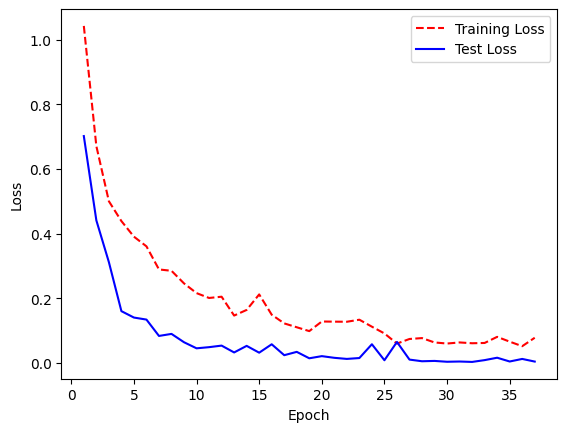

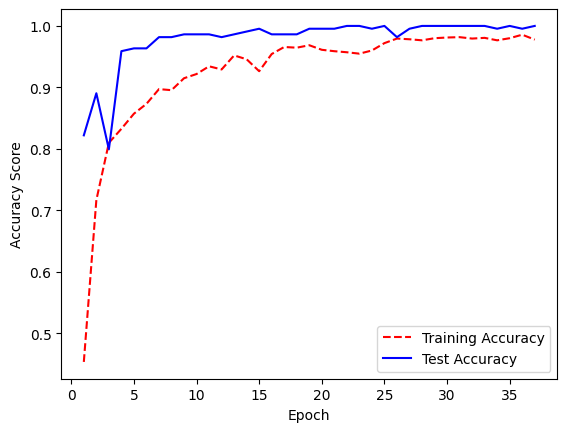

In [67]:
visualizeLoss(history=history)
visualizeAccuracy(history=history)

In [69]:
model = tf.keras.models.load_model('best_model_final.h5')
#model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),loss=customLossFunction,metrics=['accuracy'])

In [70]:
print(model.evaluate(test_data))

4/4 [==============================] - 0s 7ms/step - loss: 0.0271 - accuracy: 0.9954
[0.027104299515485764, 0.9954338073730469]


In [71]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,target_names = subfolders,digits=5))

14/14 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       paper    1.00000   0.99254   0.99625       134
        rock    0.99306   1.00000   0.99652       143
    scissors    1.00000   1.00000   1.00000       161

    accuracy                        0.99772       438
   macro avg    0.99769   0.99751   0.99759       438
weighted avg    0.99773   0.99772   0.99772       438



[[133   1   0]
 [  0 143   0]
 [  0   0 161]]


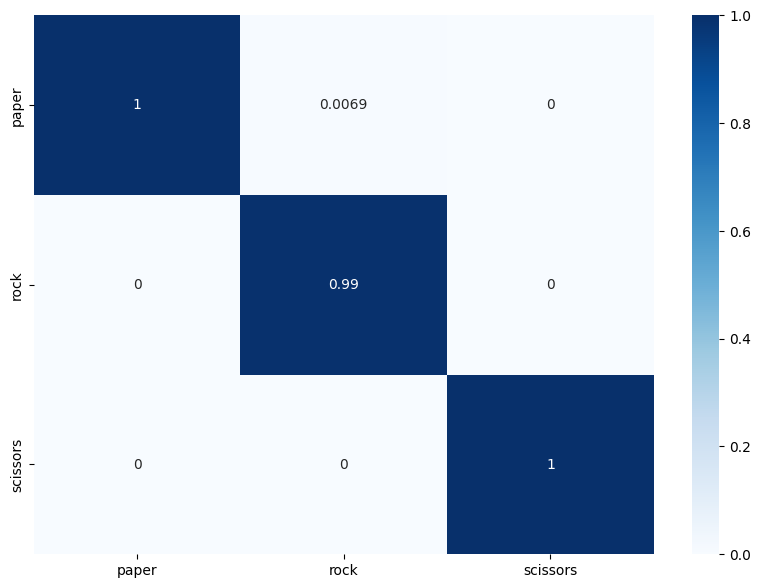

In [72]:
from sklearn.metrics import confusion_matrix
import pandas as pd

print(confusion_matrix(target_test, pred))

def plot_cfm(target_test, pred, cfm_file_name: str):
    cfm_result = confusion_matrix(target_test, pred, normalize="pred")
    classes = subfolders
    df_cfm = pd.DataFrame(cfm_result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sns.heatmap(df_cfm, annot=True,cmap=plt.cm.Blues)

plot_cfm(target_test, pred, "cfm_initial")

Iz matrice zabune vidi se da model ne pravi greške pri klasifikaciji slika papira i makaza, dok se za sliku kamena javlja minimalna greška od 0.69%.